<a href="https://colab.research.google.com/github/phmorris610/ncaaData/blob/main/ncaaMorris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### NCAA Data, by Paul Morris
We have been given NCAA college basketball analytics data, and have been tasked to make produce a model that will pick a winner. Before we make a model we should get a feel for the data, through visualization and tabulations of the statistics. Let's get started!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statistics import *
from scipy.stats import *
import seaborn as sns
from IPython.display import display, HTML
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler as Scaler

Before we load the data lets load some packages we will need. Spoiler alert, don't look too closely or you will spoil the surprise.

In [5]:
from google.colab import files
uploaded = files.upload()
ncaa = pd.read_csv('cbb.csv')

Saving cbb.csv to cbb.csv


Now lets look at the data to see what we have been given.

In [6]:
print(ncaa.shape)
print(ncaa.columns)
print(ncaa.head())

(2455, 24)
Index(['TEAM', 'CONF', 'G', 'W', 'ADJOE', 'ADJDE', 'BARTHAG', 'EFG_O', 'EFG_D',
       'TOR', 'TORD', 'ORB', 'DRB', 'FTR', 'FTRD', '2P_O', '2P_D', '3P_O',
       '3P_D', 'ADJ_T', 'WAB', 'POSTSEASON', 'SEED', 'YEAR'],
      dtype='object')
             TEAM CONF   G   W  ADJOE  ADJDE  BARTHAG  EFG_O  EFG_D   TOR  \
0  North Carolina  ACC  40  33  123.3   94.9   0.9531   52.6   48.1  15.4   
1       Wisconsin  B10  40  36  129.1   93.6   0.9758   54.8   47.7  12.4   
2        Michigan  B10  40  33  114.4   90.4   0.9375   53.9   47.7  14.0   
3      Texas Tech  B12  38  31  115.2   85.2   0.9696   53.5   43.0  17.7   
4         Gonzaga  WCC  39  37  117.8   86.3   0.9728   56.6   41.1  16.2   

   ...  FTRD  2P_O  2P_D  3P_O  3P_D  ADJ_T   WAB  POSTSEASON  SEED  YEAR  
0  ...  30.4  53.9  44.6  32.7  36.2   71.7   8.6         2ND   1.0  2016  
1  ...  22.4  54.8  44.7  36.5  37.5   59.3  11.3         2ND   1.0  2015  
2  ...  30.0  54.7  46.8  35.2  33.2   65.9   6.9         2

Let's start out by seeing how many teams there were per year

In [17]:
n2013 = ncaa[ncaa['YEAR'] == 2013]
n2014 = ncaa[ncaa['YEAR'] == 2014]
n2015 = ncaa[ncaa['YEAR'] == 2015]
n2016 = ncaa[ncaa['YEAR'] == 2016]
n2017 = ncaa[ncaa['YEAR'] == 2017]
n2018 = ncaa[ncaa['YEAR'] == 2018]
n2019 = ncaa[ncaa['YEAR'] == 2019]
Teams = f"Team amount in 2013: {len(n2013['TEAM'])}. Confrence amount in 2013: {n2013.groupby('CONF').ngroups}. " \
        f"Team amount in 2014: {len(n2014['TEAM'])}. Confrence amount in 2014: {n2014.groupby('CONF').ngroups}. " \
        f"Team amount in 2015: {len(n2015['TEAM'])}. Confrence amount in 2015: {n2015.groupby('CONF').ngroups}. " \
        f"Team amount in 2016: {len(n2016['TEAM'])}. Confrence amount in 2016: {n2016.groupby('CONF').ngroups}. " \
        f"Team amount in 2017: {len(n2017['TEAM'])}. Confrence amount in 2017: {n2017.groupby('CONF').ngroups}. " \
        f"Team amount in 2018: {len(n2018['TEAM'])}. Confrence amount in 2018: {n2018.groupby('CONF').ngroups}. " \
        f"Team amount in 2019: {len(n2019['TEAM'])}. Confrence amount in 2019: {n2019.groupby('CONF').ngroups}."
Teams

'Team amount in 2013: 347. Confrence amount in 2013: 33. Team amount in 2014: 351. Confrence amount in 2014: 33. Team amount in 2015: 351. Confrence amount in 2015: 33. Team amount in 2016: 351. Confrence amount in 2016: 32. Team amount in 2017: 351. Confrence amount in 2017: 32. Team amount in 2018: 351. Confrence amount in 2018: 32. Team amount in 2019: 353. Confrence amount in 2019: 32.'

We can see that in 2014 4 new teams entered the tournament, and in 2019 2 more entered. Also the amount of conferences started out at 33, then dropped by one in 2016.

## Now let's look at just 2019

Let's see how many teams were in each conference.

In [19]:
numPerConf = {}
for conf in n2019['CONF'].unique():
    c = n2019[n2019['CONF'] == conf]
    num = c['TEAM'].count()
    numPerConf[conf] = [num]
npc = pd.DataFrame.from_dict(numPerConf, orient='index', columns=['Teams Per Conference'])
npc

,Teams Per Conference
B12,10
ACC,15
B10,14
SEC,14
WCC,10
A10,14
AE,9
Amer,12
ASun,8
BE,10


An important thing to check for during an exploratory data analysis are outliers. Lets produce some visualizations that will help us identify them.

Index(['G', 'W', 'ADJOE', 'ADJDE', 'BARTHAG', 'EFG_O', 'EFG_D', 'TOR', 'TORD',
       'ORB', 'DRB', 'FTR', 'FTRD', '2P_O', '2P_D', '3P_O', '3P_D', 'ADJ_T',
       'WAB', 'SEED', 'YEAR'],
      dtype='object')


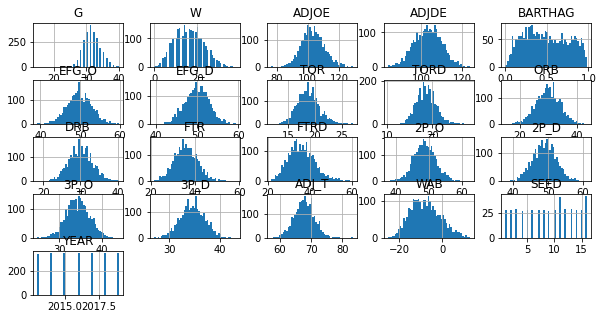

In [20]:
cNum = ncaa.select_dtypes(include=np.number)  
print(cNum.columns)
cNum.hist(bins=50, figsize=(10, 5))
plt.show()

There are some that are slightly skewed, but the distributions look pretty normal, lets look at a Boxplot to be sure.

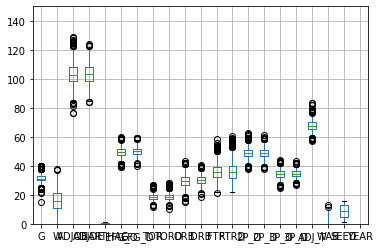

In [22]:
cNum.boxplot()
plt.ylim(0, 150)
plt.show() 

We can see some outlier, but nothing very extreme. In order to see how these outliers are effecting our metrics we can see how many observations fall out of a specified range of standard deviations, then recalculate the average. We can use this function when figuring out certain statistical relationships.

In [29]:
def zscores(x, n):
    scoresLower = []
    lowerIndex = []
    scoresUpper = []
    upperIndex = []
    for i in x:
        score = (i - mean(x)) / stdev(x)
        if score < -n:
            scoresLower.append(score)
            lowerIndex.append(i)
        if score > n:
            scoresUpper.append(score)
            upperIndex.append(i)
        else:
            pass
    outliers = lowerIndex + upperIndex
    res = [i for i in x if i not in outliers]
    print(
        'The area within 2 standard deviation represents 95% of the probability, and within 3 97.7% of the probability ')
    print(
        f'There are {len(scoresLower)} values below {n} standard deviations from the mean, the values are {lowerIndex} '
        f'There are {len(scoresUpper)} values above {n} standard deviations from the mean, the values are {upperIndex}.')
    print(
        f'The original mean was {round(mean(x), 3)}, the mean after removing outliers to {n} standard deviations is {round(mean(res), 3)}.')
    return scoresLower, scoresUpper, lowerIndex, upperIndex
  


In [30]:
np.set_printoptions(suppress=True)
ftrd_List = list(n2019['FTRD'])
efgo_List = list(n2019['EFG_O'])
efgd_List = list(n2019['EFG_D'])
n_list = list(ncaa['EFG_O'])

In [31]:
zscores(efgd_List, 3)

The area within 2 standard deviation represents 95% of the probability, and within 3 97.7% of the probability 
There are 1 values below 3 standard deviations from the mean, the values are [42.5] There are 1 values above 3 standard deviations from the mean, the values are [59.3].
The original mean was 50.775, the mean after removing outliers to 3 standard deviations is 50.774.


([-3.005744789052917], [3.096918395924114], [42.5], [59.3])

In [32]:
zscores(ftrd_List, 3)

The area within 2 standard deviation represents 95% of the probability, and within 3 97.7% of the probability 
There are 0 values below 3 standard deviations from the mean, the values are [] There are 3 values above 3 standard deviations from the mean, the values are [54.0, 50.5, 52.5].
The original mean was 33.203, the mean after removing outliers to 3 standard deviations is 33.039.


([],
 [4.0938792911628035, 3.4049209224055135, 3.7986114188382505],
 [],
 [54.0, 50.5, 52.5])

In [33]:
zscores(efgo_List, 3)

The area within 2 standard deviation represents 95% of the probability, and within 3 97.7% of the probability 
There are 2 values below 3 standard deviations from the mean, the values are [40.9, 40.0] There are 0 values above 3 standard deviations from the mean, the values are [].
The original mean was 50.601, the mean after removing outliers to 3 standard deviations is 50.659.


([-3.3011484666200714, -3.607413759180869], [], [40.9, 40.0], [])

As we can see removing the outliers really hasn't effected our metrics significantly.

## Now let's look at some of these metrics over time

Lets see how the average of Effective Field Goal Percentage Taken efg_o and Effective Field Goal Percentage Allowed efg_d have changed over time.

In [41]:
ffndf = pd.pivot_table(ncaa, index=['YEAR'], values=['EFG_O', 'EFG_D'], aggfunc=np.median, dropna=True, sort=True)
ffndf

,EFG_D,EFG_O
YEAR,,
2013,48.7,48.4
2014,49.8,49.4
2015,49.2,49.0
2016,49.9,49.8
2017,50.6,50.5
2018,50.9,50.8
2019,50.9,50.5


As we can see the averages of both metrics are increasing. Lets see some more.

In [42]:
ffndf2 = pd.pivot_table(ncaa, index=['YEAR'], values=['EFG_O', 'EFG_D', '2P_O', '2P_D', '3P_O', '3P_D', 'FTR', 'FTRD'], aggfunc=np.median, dropna=True, sort=True)
ffndf2

,2P_D,2P_O,3P_D,3P_O,EFG_D,EFG_O,FTR,FTRD
YEAR,,,,,,,,
2013,47.5,47.6,33.9,33.7,48.7,48.4,35.9,36.0
2014,48.8,48.5,34.5,34.2,49.8,49.4,40.2,40.7
2015,48.0,47.6,34.3,34.2,49.2,49.0,36.6,36.6
2016,48.9,48.7,34.8,34.5,49.9,49.8,36.8,37.1
2017,49.5,49.2,35.1,34.8,50.6,50.5,35.1,35.1
2018,50.0,49.8,35.0,34.8,50.9,50.8,33.3,33.3
2019,50.2,50.3,34.4,34.2,50.9,50.5,33.3,32.7


As we can see scoring, for and against, is increasing, but Freethrow rates, for and against, are decreasing. My initial conclusion here is that the game is become more offense centric.

Now lets see what conferences have improved and which ones havent.

In [58]:
ffndf3 = pd.pivot_table(ncaa, index=['YEAR'], columns=['CONF'], values=['EFG_O'], aggfunc=np.median, dropna=True, sort=True)
ffndf3

EFG_O                                                                \
CONF    A10    ACC    AE   ASun   Amer    B10    B12     BE   BSky   BSth   
YEAR                                                                        
2013  50.25  50.45  48.3  48.80    NaN  48.05  48.30  49.00  48.70  48.25   
2014  49.60  49.90  48.8  49.95  50.10  50.10  50.85  49.90  50.90  50.50   
2015  48.00  49.90  47.3  48.15  48.40  50.35  49.20  49.60  50.50  49.90   
2016  51.10  51.10  50.1  51.35  49.20  50.80  49.90  51.30  50.65  50.00   
2017  49.70  52.40  50.2  51.85  48.90  52.15  52.70  51.95  51.10  50.35   
2018  50.40  52.10  50.5  49.95  50.70  51.85  51.90  53.45  51.50  49.30   
2019  49.10  50.70  49.3  50.15  50.45  50.65  51.05  52.40  50.80  52.60   

      ...                                                                 \
CONF  ...    Pat     SB     SC    SEC   SWAC   Slnd    Sum    WAC    WCC   
YEAR  ...                                                                  
2013  ...  48.80  47.50  48.40  48.40  44.15  46.75  50.80  47.45  50.20   
2014  ...  50.05  47.55  48.80  49.25  46.40  49.90  49.60  48.80  50.95   
2015  ...  49.85  47.60  49.75  49.05  44.90  48.80  49.30  46.05  49.10   
2016  ...  50.10  47.50  50.70  49.05  45.65  49.90  51.30  48.70  49.45   
2017  ...  50.80  51.00  52.15  50.65  46.70  50.10  52.20  49.45  50.75   
2018  ...  52.45  49.65  52.75  51.60  46.05  48.80  52.25  48.15  50.05   
2019  ...  52.85  51.60  52.80  50.75  47.25  49.60  52.85  49.80  52.20   

             
CONF    ind  
YEAR         
2013  45.85  
2014  48.00  
2015    NaN  
2016    NaN  
2017    NaN  
2018    NaN  
2019    NaN  

[7 rows x 35 columns]

The A10 has decreased their Effective Field Goal Percentage taken, while the CAA has inreased the most.

In [59]:
ffndf3 = pd.pivot_table(ncaa, index=['YEAR'], columns=['CONF'], values=['EFG_D'], aggfunc=np.median, dropna=True, sort=True)
ffndf3

EFG_D                                                               ...  \
CONF    A10   ACC    AE   ASun   Amer    B10    B12     BE   BSky   BSth  ...   
YEAR                                                                      ...   
2013  48.85  46.8  48.2  50.05    NaN  45.55  47.45  46.20  50.40  49.25  ...   
2014  47.80  47.2  50.3  51.25  49.05  47.50  48.20  49.00  53.10  51.95  ...   
2015  48.55  47.3  50.4  50.65  45.70  47.25  46.15  47.95  52.50  51.30  ...   
2016  49.30  49.1  50.2  53.05  47.10  48.45  48.70  48.85  52.50  52.50  ...   
2017  49.90  49.1  51.9  52.80  47.10  48.20  49.30  50.35  52.25  52.30  ...   
2018  51.45  49.2  51.1  53.50  49.65  48.50  49.50  50.30  52.60  51.70  ...   
2019  49.70  48.1  52.0  52.10  48.60  48.25  48.40  50.55  52.55  51.10  ...   

                                                                            
CONF    Pat     SB     SC    SEC   SWAC   Slnd    Sum    WAC    WCC    ind  
YEAR                                                                        
2013  48.90  47.90  50.05  46.30  48.15  49.45  53.30  47.55  48.10  52.75  
2014  50.25  49.75  51.60  46.60  49.95  51.35  51.60  49.80  49.85  50.30  
2015  51.00  48.00  51.05  47.15  49.90  51.90  51.00  49.75  49.40    NaN  
2016  51.35  48.40  51.20  47.95  50.60  52.10  52.00  49.50  50.05    NaN  
2017  52.35  50.40  50.45  47.95  51.25  51.90  53.50  47.85  51.55    NaN  
2018  52.60  49.95  53.20  48.50  51.85  51.70  51.25  49.30  51.85    NaN  
2019  52.70  51.85  52.65  49.40  52.15  51.20  53.80  49.90  49.60    NaN  

[7 rows x 35 columns]

BE has increased in Effective Field Goal Allowed significantly, so have CAA, Horz, and MEAC

Now let's see which conference has won the most championships

In [63]:
champ = ncaa[ncaa['POSTSEASON'] == 'Champions']
champ.sort_values(by=['CONF'], ascending=False)

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR
10,Villanova,BE,40,35,123.1,90.9,0.9703,56.1,46.7,16.3,...,30.0,57.4,44.1,36.2,33.9,66.7,8.9,Champions,2.0,2016
11,Villanova,BE,40,36,128.4,94.1,0.9725,59.5,48.5,15.0,...,26.7,59.0,49.0,40.1,31.7,69.6,10.6,Champions,1.0,2018
13,Louisville,BE,40,35,115.9,84.5,0.9743,50.6,44.8,18.3,...,34.9,50.8,43.4,33.3,31.8,67.1,9.0,Champions,1.0,2013
12,Connecticut,Amer,40,32,112.5,91.3,0.9171,51.5,44.6,17.3,...,35.7,48.1,42.2,38.7,33.0,64.8,4.7,Champions,7.0,2014
7,Duke,ACC,39,35,125.2,90.6,0.9764,56.6,46.5,16.3,...,23.9,55.9,46.3,38.7,31.4,66.4,10.7,Champions,1.0,2015
8,Virginia,ACC,38,35,123.0,89.9,0.9736,55.2,44.7,14.7,...,26.3,52.5,45.7,39.5,28.9,60.7,11.1,Champions,1.0,2019
9,North Carolina,ACC,39,33,121.0,91.5,0.9615,51.7,48.1,16.2,...,31.6,51.0,46.3,35.5,33.9,72.8,8.4,Champions,1.0,2017


Looks like the Big East has the most championships and Villanova have won the most titles in this time frame, in 2016, and in 2018.

Lets look at one more statistic, Turnover Percentage Allowed, (TOR)

In [80]:
feat = ['TEAM','TOR']
tor = ncaa[feat]
tor.sort_values(ascending=False, by='TOR')

,TEAM,TOR
1831,Savannah St.,27.1
1756,Grambling St.,26.8
1354,Grambling St.,26.1
1371,Arkansas Pine Bluff,25.9
1790,Manhattan,25.7
...,...,...
2324,Delaware,13.4
1530,Drexel,12.9
53,Wisconsin,12.7
1,Wisconsin,12.4


Savanna St is the worst at 27.1, and Georgia St is the best at 11.9

## Now lets have some fun and build a model to predict a winner.

Our response variable will be making the Final Four (which of course includes beyond) or not. Also we will use 2013-2018 as the training set, with 2019 as the testing set.

In [67]:
feat = ['TEAM', 'CONF', 'EFG_O', 'EFG_D', 'FTR', '2P_O', '3P_O', 'SEED', 'YEAR']
ffFeat = ['F4', '2ND', 'Champions']
ffNotFeat = ['R32' 'R64' 'R68' 'S16', 'E8']
ff = ncaa[ncaa['POSTSEASON'].isin(['F4', '2ND', 'Champions'])]
ff = ff[feat]
ffNot = ncaa[ncaa['POSTSEASON'].isin(['R32' 'R64' 'R68' 'S16', 'E8'])]
ffNot = ffNot[feat]

In [68]:
ffdf = pd.pivot_table(ff, index=["TEAM", "YEAR"], values=['EFG_O', 'EFG_D', '2P_O', '3P_O'], aggfunc=np.max, sort=True)
ffdf

2P_O  3P_O  EFG_D  EFG_O
TEAM           YEAR                          
Auburn         2019  51.7  38.1   51.7   54.4
Connecticut    2014  48.1  38.7   44.6   51.5
Duke           2015  55.9  38.7   46.5   56.6
Florida        2014  51.3  35.9   45.4   52.2
Gonzaga        2017  56.3  38.2   41.1   56.6
Kansas         2018  55.6  40.1   49.1   57.5
Kentucky       2014  50.0  33.2   46.0   49.9
               2015  51.2  34.9   39.6   51.5
Louisville     2013  50.8  33.3   44.8   50.6
Loyola Chicago 2018  56.6  39.8   47.4   57.7
Michigan       2013  53.4  37.9   48.0   54.6
               2018  54.7  35.2   47.7   53.9
Michigan St.   2015  50.8  38.5   44.9   53.2
               2019  54.3  37.8   43.9   55.2
North Carolina 2016  53.9  32.7   48.1   52.6
               2017  51.0  35.5   48.1   51.7
Oklahoma       2016  48.2  42.2   47.2   54.3
Oregon         2017  54.5  38.0   46.4   55.5
South Carolina 2017  45.9  33.4   45.5   47.3
Syracuse       2013  48.5  33.4   42.6   49.0
               2016  47.2  36.0   47.3   50.0
Texas Tech     2019  52.8  36.5   43.0   53.5
Villanova      2016  57.4  36.2   46.7   56.1
               2018  59.0  40.1   48.5   59.5
Virginia       2019  52.5  39.5   44.7   55.2
Wichita St.    2013  49.6  33.9   45.3   50.0
Wisconsin      2014  51.3  37.6   47.2   53.3
               2015  54.8  36.5   47.7   54.8

In [69]:
ffndf = pd.pivot_table(ffNot, index=["TEAM", "YEAR"], values=['EFG_O', 'EFG_D', '2P_O', '3P_O'], aggfunc=np.max)
ffndf

2P_O  3P_O  EFG_D  EFG_O
TEAM         YEAR                          
Arizona      2014  50.7  36.4   42.3   51.7
             2015  53.3  36.0   45.1   53.5
Dayton       2014  50.4  37.7   48.8   52.4
Duke         2013  50.8  39.9   45.5   53.9
             2018  56.0  37.2   46.4   55.9
             2019  58.0  30.8   45.0   53.6
Florida      2013  54.3  37.8   43.3   55.2
             2017  50.3  35.9   45.8   51.6
Florida St.  2018  53.6  35.0   48.4   53.2
Gonzaga      2015  57.0  40.0   44.2   57.9
             2019  61.4  36.3   44.2   59.0
Kansas       2016  52.7  41.3   45.1   55.7
             2017  53.6  40.4   48.1   56.1
Kansas St.   2018  53.4  34.1   49.1   52.6
Kentucky     2017  52.9  35.3   47.5   52.9
             2019  52.9  35.4   46.6   53.0
Louisville   2015  48.4  30.7   44.0   47.7
Marquette    2013  51.6  29.6   46.2   49.6
Michigan     2014  52.7  40.2   49.4   55.7
Michigan St. 2014  52.1  39.2   45.8   54.5
Notre Dame   2015  58.2  39.0   47.9   58.3
             2016  52.9  37.4   49.5   54.0
Ohio St.     2013  49.4  35.6   45.4   50.6
Oregon       2016  52.6  34.4   48.9   52.3
Purdue       2019  51.5  37.4   49.0   53.6
Texas Tech   2018  51.1  35.9   46.4   52.0
Virginia     2016  52.6  40.3   48.4   54.8
Xavier       2017  52.0  34.5   51.6   51.9

The first table are teams that made the Final Four during this time, and the second are teams that did not. In the one and done era it is very hard to make sense of these numbers, lets let our model do the heavy lifting here.

In [70]:
ncaa['response'] = np.where(((ncaa['POSTSEASON'] == 'F4') |
                             (ncaa['POSTSEASON'] == '2ND') | (ncaa['POSTSEASON'] == 'Champions')), 1, 0)

In [71]:
X_train = ncaa[ncaa['YEAR'] != 2019]
X_train = X_train.copy()
y_train = X_train.pop('response')
X_test = ncaa[ncaa['YEAR'] == 2019]
X_test = X_test.copy()
y_test = X_test.pop('response')
X_train.drop('POSTSEASON', axis=1, inplace=True)
X_train.drop('SEED', axis=1, inplace=True)
X_test.drop('POSTSEASON', axis=1, inplace=True)
X_test.drop('SEED', axis=1, inplace=True)

After making the response, and then splitting, lets see which varialbes are correlated to making the Final Four and which onces are not.

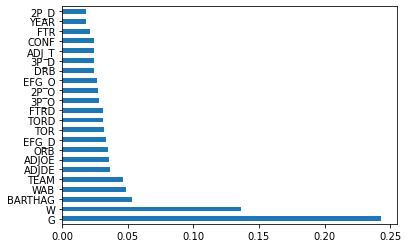

[G          0.242960
 W          0.136064
 BARTHAG    0.053617
 WAB        0.048588
 TEAM       0.046195
 ADJDE      0.036406
 ADJOE      0.035500
 ORB        0.034760
 EFG_D      0.033104
 TOR        0.032153
 TORD       0.031291
 FTRD       0.031039
 3P_O       0.028439
 2P_O       0.027274
 EFG_O      0.026850
 DRB        0.024661
 3P_D       0.024610
 ADJ_T      0.024582
 CONF       0.024427
 FTR        0.020937
 YEAR       0.018399
 2P_D       0.018143
 dtype: float64]

In [74]:
def extraTree(x, y, n):
    model = ExtraTreesClassifier()
    model.fit(x, y)
    feat_importances = pd.Series(model.feature_importances_, index=x.columns)
    feat_importances.nlargest(n).plot(kind='barh')
    plt.show()
    feat = []
    feat.append(feat_importances.nlargest(n))
    #print(f'The {n} Features most correlated with the response are: {feat_importances}')
    return feat

for colname in X_train.select_dtypes('object').columns:
    X_train[colname], _ = X_train[colname].factorize()
for colname in X_test.select_dtypes('object').columns:
     X_test[colname], _ = X_test[colname].factorize()

extraTree(X_train, y_train, 40)

Here are the most correlated variables to making the Final Four, Games and wins are in the lead of course, but also Power Rating, Wins above Bubble, and Adjusted Offense and Defense Efficiency.

In [75]:
scaler = Scaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
scaler.fit(X_test)
X_test = scaler.transform(X_test)

After scaling the data, let's put it through a Support Vector Machine model.

In [76]:
model1 = svm.SVC(kernel='poly', degree=2)
model1.fit(X_train, y_train)
y_pred = model1.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1_score = f1_score(y_test, y_pred)
print(f'Accuracy for our SVM is: {accuracy} Precision for our SVM is: {precision}')
print(f'Recall for our SVM is: {recall}    F1 Measure for our SVM is: {f1_score}')
print("")

Accuracy for our SVM is: 0.9971671388101983 Precision for our SVM is: 1.0
Recall for our SVM is: 0.75    F1 Measure for our SVM is: 0.8571428571428571



Our results are phenomenal, lets check.

In [77]:
modelPrediction = list(model1.predict(X_test))
moPred = []
for index, item in enumerate(modelPrediction, 0):
    if item == 1:
        moPred.append(index)
    else:
        pass

In [78]:
print(ncaa[ncaa['YEAR'] == 2019].iloc[1], ncaa[ncaa['YEAR'] == 2019].iloc[6], ncaa[ncaa['YEAR'] == 2019].iloc[7])

TEAM           Virginia
CONF                ACC
G                    38
W                    35
ADJOE             123.0
ADJDE              89.9
BARTHAG          0.9736
EFG_O              55.2
EFG_D              44.7
TOR                14.7
TORD               17.5
ORB                30.4
DRB                25.4
FTR                29.1
FTRD               26.3
2P_O               52.5
2P_D               45.7
3P_O               39.5
3P_D               28.9
ADJ_T              60.7
WAB                11.1
POSTSEASON    Champions
SEED                1.0
YEAR               2019
response              1
Name: 8, dtype: object TEAM          Michigan St.
CONF                   B10
G                       39
W                       32
ADJOE                119.9
ADJDE                 91.0
BARTHAG             0.9597
EFG_O                 55.2
EFG_D                 43.9
TOR                   18.5
TORD                  14.9
ORB                   33.9
DRB                   26.4
FTR                   33.6

Our model predicted Viginia, Michigan St, and Auburn to make the Final Four.

In [79]:
feats = ['TEAM', 'POSTSEASON']
df1 = pd.DataFrame(n2019, columns=feats)
df1

,TEAM,POSTSEASON
3,Texas Tech,2ND
8,Virginia,Champions
20,Duke,E8
21,Purdue,E8
31,Kentucky,E8
...,...,...
2408,Houston,S16
2416,Michigan,S16
2431,Oregon,S16
2435,LSU,S16


Looks like it correctly predicted 3 out of 4. Not exactly a 99.1 percent accuracy, but we do have an F1-Measure of 85%

Given more time I would like to try other models, but also to dig into the model metrics, and to try different hyperparameters in order to correctly classify the 4th Final Four attendee. Also I would like to look into what Texas Tech did differently in order to throw off our model. I will leave these tasks to another day.